In [144]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [145]:
MINIMUM_PEPTIDE_SCORE = 30
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [182]:
my_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/F359932.csv', sep=',', index_col=False, skiprows=61)
my_results_df = my_results_df[my_results_df.pep_score >= MINIMUM_PEPTIDE_SCORE]


In [183]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/F359466.csv', sep=',', index_col=False, skiprows=61)
mq_results_df = mq_results_df[mq_results_df.pep_score >= MINIMUM_PEPTIDE_SCORE]

In [184]:
len(my_results_df), len(mq_results_df)

(464, 171)

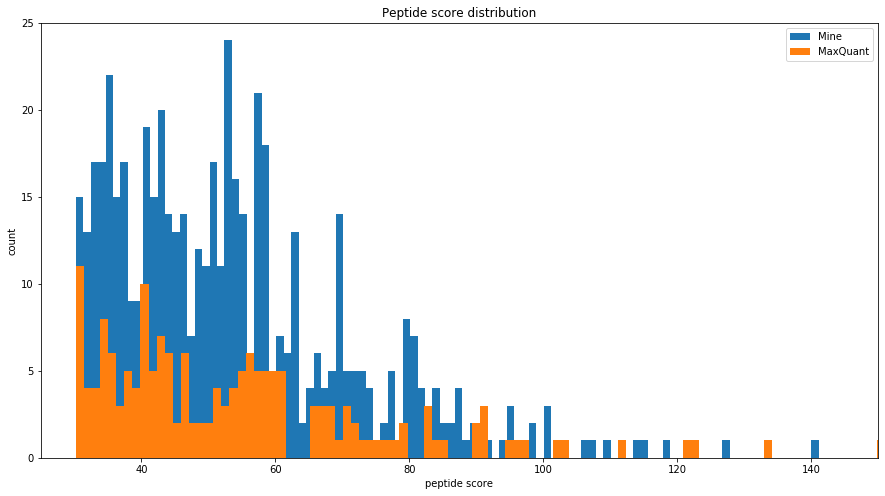

In [180]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score distribution')

h_bins = 100
hist, bins, _ = plt.hist(my_results_df.pep_score, bins=h_bins, label='Mine')
hist, bins, _ = plt.hist(mq_results_df.pep_score, bins=h_bins, label='MaxQuant')
plt.legend(loc='best')
plt.xlabel('peptide score')
plt.ylabel('count')

plt.xlim([25,150])
plt.ylim([0,25])

plt.show()

In [149]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

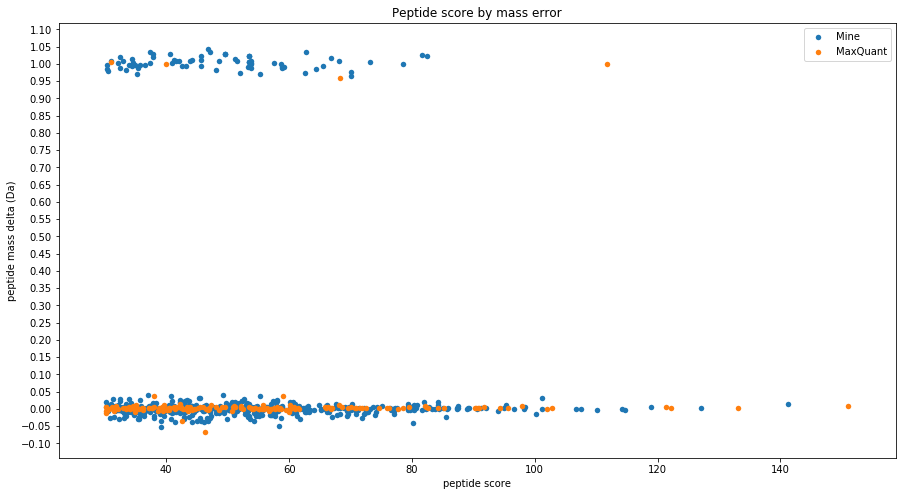

In [150]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score by mass error')

ax.scatter(my_results_df.pep_score, my_results_df.pep_delta, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")
ax.scatter(mq_results_df.pep_score, mq_results_df.pep_delta, marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="MaxQuant")

plt.legend(loc='best')
plt.xlabel('peptide score')
plt.ylabel('peptide mass delta (Da)')
plt.yticks(np.arange(-0.1,1.1,0.05))

plt.show()

In [151]:
# number of peptide matches
my_peptides = list(my_results_df.pep_seq.unique())
mq_peptides = list(mq_results_df.pep_seq.unique())

In [195]:
my_results_df.pep_seq.unique()[:10]

array(['ILDSVGIEADDDR', 'ILDSVGIEADDDRLNK', 'TSRPENAIIYNNNEDFQVGQAK',
       'TTPSVVAFTADGER', 'SQVFSTAADGQTQVEIK', 'DLAEDAPWK',
       'EAGAGGLAIAVEGPSK', 'THIQDNHDGTYTVAYVPDVTGR', 'AGPGTLSVTIEGPSK',
       'AEGPDVAVDLPK'], dtype=object)

In [244]:
my_results_df['retention_time'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[9]))
my_results_df['feature_id'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[7]))
my_results_df['intensity'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[5]))

In [246]:
p_df = my_results_df[my_results_df.pep_seq == 'TSRPENAIIYNNNEDFQVGQAK'][['pep_exp_mz','retention_time','pep_delta','pep_exp_z','feature_id','intensity']]
p_df

,pep_exp_mz,retention_time,pep_delta,pep_exp_z,feature_id,intensity
8,836.7390,3060.34,-0.0088,3,376,178412.0
9,836.7425,3059.92,0.0017,3,39,913832.0
10,627.8107,3059.35,0.0096,4,100,482899.0
11,836.7469,3059.78,0.0147,3,8,2573469.0


In [226]:
ms1_dedup_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/rt-3000-3060-nddms1.pkl')

In [234]:
list(p_df.feature_id)

[376, 39, 100, 8]

In [247]:
df = ms1_dedup_features_df[ms1_dedup_features_df.feature_id.isin(list(p_df.feature_id))]
df[['envelope','monoisotopic_mz','intensity']]

,envelope,monoisotopic_mz,intensity
7,"((836.7477, 619192.00), (837.0813, 852415.00),...",836.746865,2573469.0
38,"((836.7437, 211275.00), (837.0770, 297742.00),...",836.742510,913832.0
99,"((627.8107, 116204.00), (628.0613, 151981.00),...",627.810678,482899.0
375,"((836.7399, 42711.00), (837.0729, 58258.00), (...",836.739038,178412.0


In [254]:
df.mono_adjusted

7      False
38     False
99     False
375    False
Name: mono_adjusted, dtype: bool

In [252]:
envelope_intensity = 0
for i in range(len(df.iloc[0].envelope)):
    envelope_intensity += df.iloc[0].envelope[i][1]
envelope_intensity

2573469.0

In [250]:
df.iloc[0].monoisotopic_mz - df.iloc[3].monoisotopic_mz

0.007826624113022262

In [242]:
mz_ppm_tolerance = df.iloc[0].monoisotopic_mz * (5 * 10**-4) / 100
mz_ppm_tolerance

0.004183734325017443

In [204]:
mq_results_df.iloc[0].pep_scan_title

'RawFile: HeLa_20KInt_2KIT_Slot1-46_01_1179 Index: 32703 Charge: 2 FeatureIntensity: 509830 RtApex: 3027.22'

Question: for the features detected in common, what did each algorithm identify it as?
* for each feature detected by PDA (PASEF-driven approach) and identified, find a matching feature in MQ (RT, PEPMASS, charge)
* get the Index from MQ, and the precursor ID from PDA
* what peptide was each identified as? how did the scores differ?

In [256]:
my_results_df.columns

Index(['prot_hit_num', 'prot_family_member', 'prot_acc', 'prot_desc',
       'prot_score', 'prot_mass', 'prot_matches', 'prot_matches_sig',
       'prot_sequences', 'prot_sequences_sig', 'pep_query', 'pep_rank',
       'pep_isbold', 'pep_isunique', 'pep_exp_mz', 'pep_exp_mr', 'pep_exp_z',
       'pep_calc_mr', 'pep_delta', 'pep_miss', 'pep_score', 'pep_expect',
       'pep_res_before', 'pep_seq', 'pep_res_after', 'pep_var_mod',
       'pep_var_mod_pos', 'pep_summed_mod_pos', 'pep_scan_title',
       'retention_time', 'charge', 'feature_id', 'intensity'],
      dtype='object')

In [261]:
mq_results_df['retention_time'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[9]))
mq_results_df['Index'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[3]))
mq_results_df['intensity'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[7]))

In [262]:
mq_results_df.iloc[0].pep_scan_title

'RawFile: HeLa_20KInt_2KIT_Slot1-46_01_1179 Index: 32703 Charge: 2 FeatureIntensity: 509830 RtApex: 3027.22'

In [287]:
match_count = 0
match_l = []
for idx,row in my_results_df.iterrows():
    # m/z criteria
    mz = row.pep_exp_mz
    mz_ppm_tolerance = mz * (10 * 10**-4) / 100
    mz_lower = mz - mz_ppm_tolerance
    mz_upper = mz + mz_ppm_tolerance
    # RT criteria
    rt = row.retention_time
    rt_lower = rt - 2
    rt_upper = rt + 2
    # charge criteria
    charge = row.pep_exp_z
    # find match in the MQ features
    mq_matches = mq_results_df[(mq_results_df.pep_exp_mz >= mz_lower) & (mq_results_df.pep_exp_mz <= mz_upper) & (mq_results_df.retention_time >= rt_lower) & (mq_results_df.retention_time <= rt_upper) & (mq_results_df.pep_exp_z == charge)]
    if len(mq_matches) >= 1:
        match_count += 1
        highest_score_mq_match = mq_matches.loc[mq_matches.pep_score.idxmax()]
        feature_id = row.feature_id
        pda_pep_score = row.pep_score
        mq_index = highest_score_mq_match.Index
        mq_pep_score = highest_score_mq_match.pep_score
        # is the identified peptide the same one or different?
        same_peptide = (highest_score_mq_match.pep_seq == row.pep_seq)
        match_l.append((feature_id, pda_pep_score, mq_index, mq_pep_score, same_peptide))
print("{} PDA identified features matched MQ features".format(match_count))

120 PDA identified features matched MQ features


In [289]:
matches_df = pd.DataFrame(match_l, columns=['pda_feature_id','pda_pep_score','mq_index','mq_pep_score','same_peptide'])

In [290]:
matches_df.head()

,pda_feature_id,pda_pep_score,mq_index,mq_pep_score,same_peptide
0,59,67.78,48273,79.60,True
1,6,82.33,48273,79.60,True
2,184,50.79,17173,55.15,True
3,49,36.90,17173,55.15,True
4,560,52.06,93704,50.95,True


In [301]:
pda_only = my_results_df[my_results_df.feature_id.isin(matches_df.pda_feature_id)]

In [302]:
mq_only = mq_results_df[mq_results_df.Index.isin(matches_df.mq_index)]

In [153]:
intersection = len(set(mq_peptides).intersection(my_peptides))

In [154]:
print("my results had {} peptides, MQ had {} peptides, and there were {} in common".format(len(my_peptides), len(mq_peptides), intersection))

my results had 312 peptides, MQ had 149 peptides, and there were 117 in common


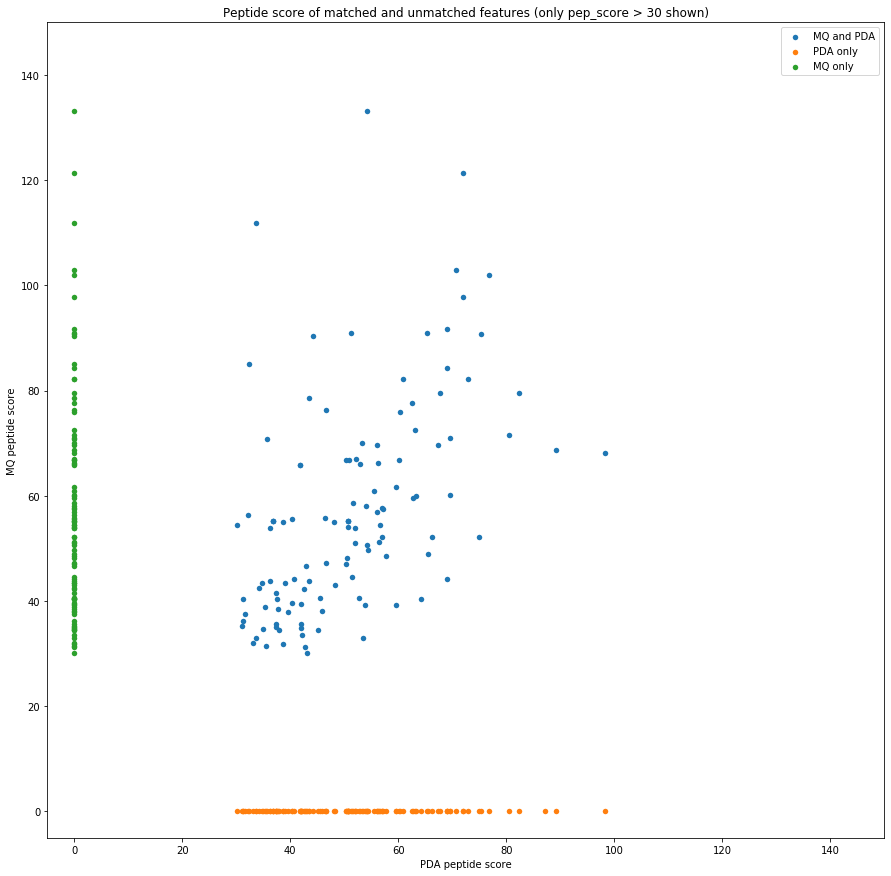

In [312]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score of matched and unmatched features (only pep_score > 30 shown)')

ax.scatter(matches_df.pda_pep_score, matches_df.mq_pep_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="MQ and PDA")
ax.scatter(pda_only.pep_score, np.full((len(pda_only)), 0), marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="PDA only")
ax.scatter(np.full((len(mq_only)), 0), mq_only.pep_score, marker='o', color=tableau20_mpl[4], lw=0, s=30, alpha=1.0, label="MQ only")

plt.legend(loc='best')
plt.xlabel('PDA peptide score')
plt.ylabel('MQ peptide score')

plt.xlim([-5,150])
plt.ylim([-5,150])

plt.show()

In [155]:
count_list = []
count_list.append(('PASEF', len(my_peptides)))
count_list.append(('MaxQuant', len(mq_peptides)))
count_list.append(('Common', intersection))

In [156]:
count_df = pd.DataFrame(count_list, columns=['method','peptide_count'])

In [157]:
count_df

,method,peptide_count
0,PASEF,312
1,MaxQuant,149
2,Common,117


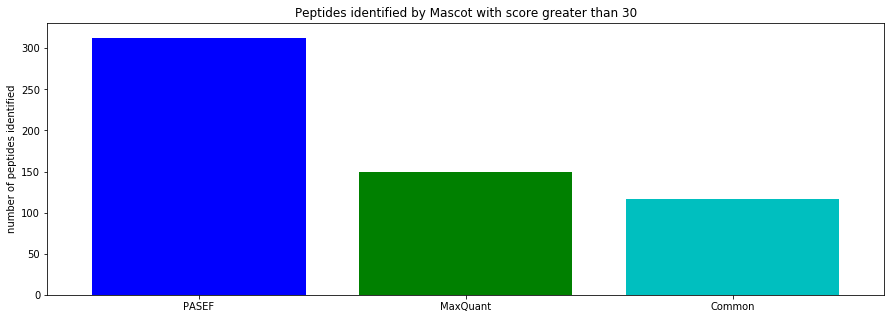

In [158]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.bar(count_df.iloc[0].method, count_df.iloc[0].peptide_count, align='center', width=0.8, color='b')
plt.bar(count_df.iloc[1].method, count_df.iloc[1].peptide_count, align='center', width=0.8, color='g')
plt.bar(count_df.iloc[2].method, count_df.iloc[2].peptide_count, align='center', width=0.8, color='c')
plt.ylabel('number of peptides identified')
plt.title('Peptides identified by Mascot with score greater than {}'.format(MINIMUM_PEPTIDE_SCORE))
plt.margins(0.06)
plt.show()

In [159]:
my_results_df.columns

Index(['prot_hit_num', 'prot_family_member', 'prot_acc', 'prot_desc',
       'prot_score', 'prot_mass', 'prot_matches', 'prot_matches_sig',
       'prot_sequences', 'prot_sequences_sig', 'pep_query', 'pep_rank',
       'pep_isbold', 'pep_isunique', 'pep_exp_mz', 'pep_exp_mr', 'pep_exp_z',
       'pep_calc_mr', 'pep_delta', 'pep_miss', 'pep_score', 'pep_expect',
       'pep_res_before', 'pep_seq', 'pep_res_after', 'pep_var_mod',
       'pep_var_mod_pos', 'pep_summed_mod_pos', 'pep_scan_title'],
      dtype='object')

In [160]:
my_results_df['feature_id'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[7]))
ms1_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/ms1_deduped_df.pkl')
my_results_df = pd.merge(my_results_df, ms1_features_df, how='left', left_on=['feature_id'], right_on=['feature_id'])

In [161]:
denom = (my_results_df.pep_calc_mr + (my_results_df.charge * PROTON_MASS)) / PROTON_MASS
pep_ppm = (my_results_df.pep_delta / denom) * 1e6
my_results_df['pep_ppm'] = round(pep_ppm).astype(int)

In [162]:
my_results_df = my_results_df[(my_results_df.pep_ppm > -100) & (my_results_df.pep_ppm < 100)]

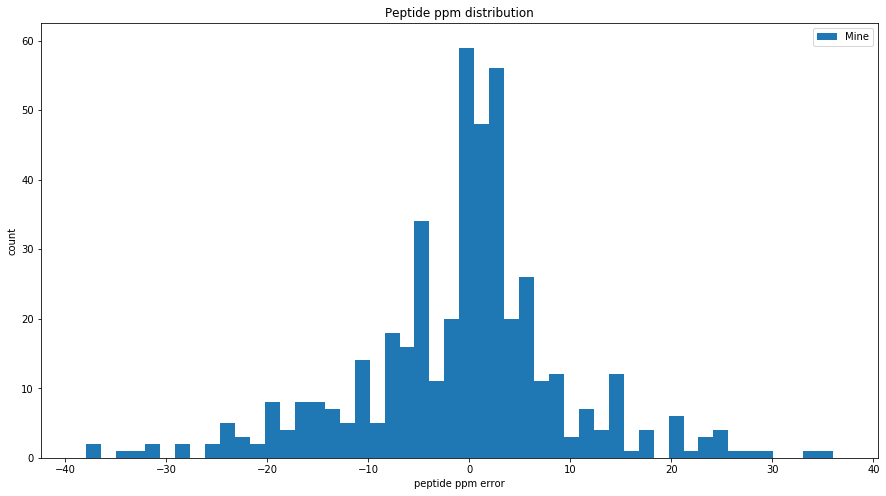

In [163]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide ppm distribution')

bins = 50
hist, bins, _ = plt.hist(my_results_df.pep_ppm, bins=bins, label='Mine')
plt.legend(loc='best')
plt.xlabel('peptide ppm error')
plt.ylabel('count')

plt.show()

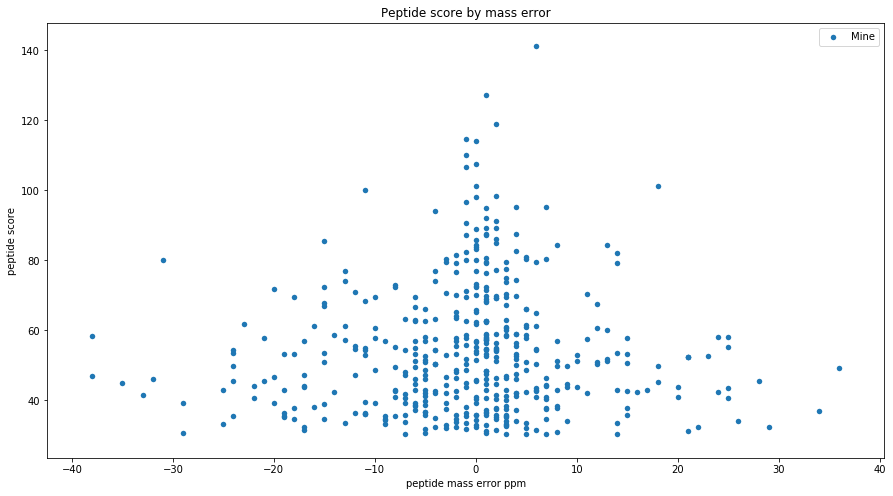

In [164]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score by mass error')

ax.scatter(my_results_df.pep_ppm, my_results_df.pep_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('peptide score')

plt.show()

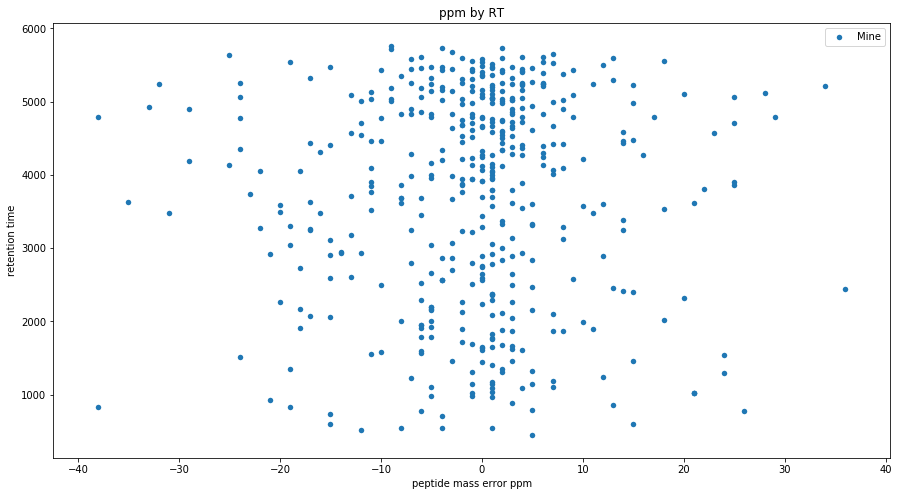

In [165]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by RT')

ax.scatter(my_results_df.pep_ppm, my_results_df.rt_apex, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('retention time')

plt.show()

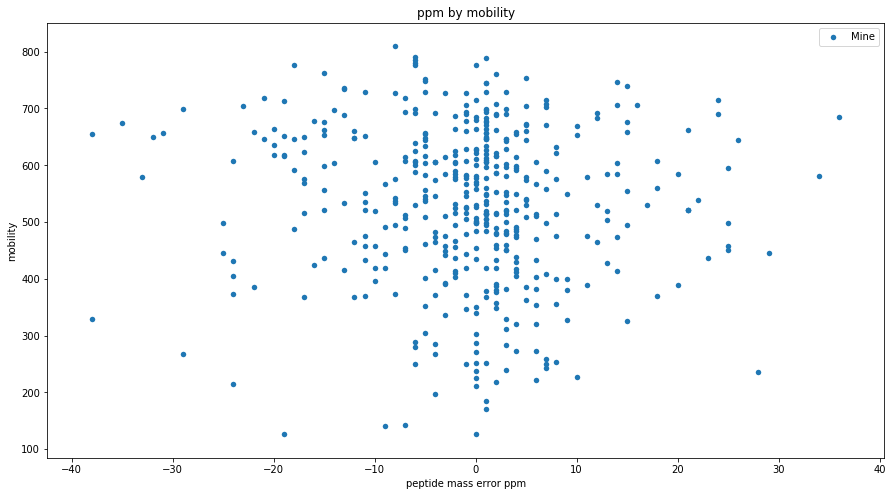

In [166]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by mobility')

ax.scatter(my_results_df.pep_ppm, my_results_df.scan_apex, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('mobility')

plt.show()